In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

## Before you begin:
- This exercise is due at noon on March 17th.
- [micrograd](https://github.com/karpathy/micrograd) is already included in this repository, but you might need to install [sklearn](https://scikit-learn.org/stable/install.html) to be able to generate data sets.

# Automatic differentiation

The aim of this exercise is to get familiar with automatic differentiation using [micrograd](https://github.com/karpathy/micrograd). Refer to the [lecture on automatic differentiation](https://computational-physics.tripos.org/notes/autodiff.html) for background theory, and to [Karpathy's YouTube video](https://www.youtube.com/watch?v=VMj-3S1tku0) for how micrograd works (for general interest: it's not necessary for completing the exercise).

## Micrograd

Micrograd is a very simple library. The core `engine` module implements a single class `Value`. Objects of this class can be composed by the common arithmetical operations (addition, multiplication, powers, etc.) to give a new object of the same class. They also have a method `backward` that computes the gradient of a value with respect to the values on which it depends. A value has a `data` property which holds the actual value and a `grad` property that holds the gradient with respect to this value. `Value.data` and `Value.grad` can be set in the usual way.

Here's a simple example:

In [37]:
x = Value(4)
f = x**3
f.backward()
print(x)
x.data = 5
f.backward()
print(x)


Value(data=4, grad=48)
Value(data=5, grad=123)


Note that the gradients accumulate unless you explicitly set `x.grad=0` between calls to `backward`. This is a feature of autodiff libraries like [PyTorch](https://pytorch.org/), though we won't be using it.

The module `nn` implements simple neural networks. These all have 

1. A `parameters` method that returns all the model parameters. Note that it returns a list of Values, not a NumPy array, so for once you'll need to write your own explicit loops to update the parameters!
2. A `zero_grad` method that zeros the gradients of all the parameters in the model. This needs to be called between training steps.

## Data

We will consider a simple artificial classification task of determining the boundary between two circles. The inner circle has radius 0.8 and the outer circle has radius 1.0.

First, we want to generate a data set to train our neural network on. To do so, we use the package sklearn to generate a data set of two circles with noise and plot them. Feel free to play with the numbers of samples and the noise!

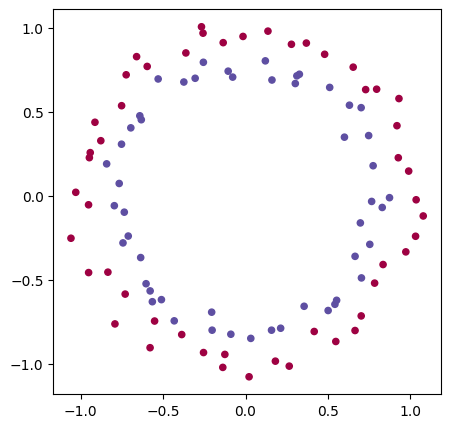

In [38]:
# generate a data set

from sklearn.datasets import make_circles
X, y = make_circles(n_samples=100, noise=0.05)

y = y*2 - 1 # make y be -1 or 1 for outer and inner circle respectively.

# visualise the data in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='Spectral')

Next, we would like to construct a neural network and train it to differentiate between the inner and outer circles. We start by constructing a 2-layer neural network with micrograd:

In [39]:
# initialise a neural network

def initialise(n_neurons):
    """Function that initialises a 2-layer neural network with n_neruons neurons in each layer."""
    
    model = MLP(2, [n_neurons, n_neurons, 1]) # 2-layer neural network
    print(model)
    print("number of parameters", len(model.parameters()))
    
    return model
    
model = initialise(n_neurons=16)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


## Task 1: Loss function

The aim of training the neural network is to best fit the input data $X_i$ to the desired output data $y_i$. We want to measure the total performance of the neural network through a loss function. A simple example of a loss function is the quadratic loss
\begin{equation}
C(\theta) = \frac{1}{2N}\sum_{i=1}^{N}||y_i - \mathrm{NN}_{\theta}(X_i)||^2,
\end{equation}
where $\theta$ are the parameters of the neural network $\mathrm{NN}_\theta$ and $N$ is the number of data points.

A slightly more complicated loss function is the SVM max-margin loss, which penalises misclassifications. It is defined as
\begin{equation}
C_{\mathrm{SVM}}(\theta) = \frac{1}{N}\sum_{i=1}^{N} \max(0, 1 - y_i*\mathrm{NN}_{\theta}(X_i)).
\end{equation}

To avoid overfitting, we can use a technique known as regularisation, which penalises large coefficients in the parameters of the neural network. This contribution to the loss function has been implemented for you.

In this task, you should write a loss function with additional regularisation. The function should return both the total loss and the accuracy of the neural network. Try both the quadratic loss and the SVM max-margin loss. Note that the $\max$ function in the SVM max-margin loss should be implemented using `Value.relu()`.

In [40]:
def loss(Xdat,ydat,model):
    """Returns the total loss (C(theta) + regularisation) and the accuracy of the neural network."""
    
    inputs = [list(map(Value, xrow)) for xrow in Xdat]
    scores = list(map(model, inputs))
    
    # compute data loss
    # svm "max-margin" loss - from micrograd demo example
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(ydat, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))

    total_loss = data_loss + reg_loss #loss function + regularisation

    accuracy = np.mean([(yi > 0) == (scorei.data > 0) for yi, scorei in zip(ydat, scores)])
    #Have taken the mean, otherwise it will be just true/false statements
    
    return total_loss, accuracy

## Task 2: Gradient descent optimiser

Having a data set, a neural network and a loss function, it is time to train the neural network, i.e. to optimise the parameters of the neural network to give the desired outcome $y$ for input data $X$. The loss measures how well the neural network predicts the desired outcome, and if the loss is low, the neural network performs well. Thus, we would like to adjust the parameters of the neural network to minimise the loss function. 

The simplest way to adjust the neural network parameters in order to minimise the loss $C(\theta)$ is by using a plain gradient descent, where one changes the value of a parameter $\theta_i$ proportionally to the derivative of the loss with respect to the said parameter, i.e. 

\begin{equation}
\theta_i \to \theta_i - \eta \frac{\partial C}{\partial \theta_i}.
\end{equation}

To find the derivative of the loss function with respect to the parameters of the neural network, we use backpropagation with micrograd. 

In this task, you are asked to write a function that uses gradient descent to optimise the parameters of the neural network with respect to the data $X$ and $y$. Here, it might be good to use a learning rate schedule where the rate $\eta$ is adjusted during training to optimize convergence. This could for instance be implemented by linearly decreasing the learning rate throughout the optimisation.

In [41]:
def learning_rate(i, n_steps):
    '''Returns a linearly decreasing learning rate.'''
    return 1.0 - 0.99*i/n_steps

In [42]:
def gd(model, n_steps=100):
    '''
    A function that optimises the parameters of the neural network in n_steps steps using gradient descent.
    Return a list of losses and a list of accuracies during training 
    '''
    
    losses = []
    accuracies = []

    for step in range(n_steps):

        # forward pass
        total_loss, acc = loss(X, y, model)
        losses.append(total_loss.data)
        accuracies.append(acc) # take mean of accuracy list to get overall accuracy

        # backward pass
        model.zero_grad()  
        total_loss.backward()

        # update

        lr = learning_rate(step, n_steps)

        for p in model.parameters():
                p.data -= lr * p.grad     

        if step % 10 == 0 or step == n_steps-1:
            print(f"step {step} loss {total_loss.data}, accuracy {acc*100}%") #Changed the code in the accuracy value so i stop getting true, false statements

    
    return losses, accuracies

Now try training your network. You may find you need to change the learning rate depending on the loss function that you use. _Warning_: The quadratic loss doesn't seem to do particularly well on this task!

In [43]:
modelgd = initialise(n_neurons=16)
lossgd, accgd = gd(modelgd)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 1.2263740747529188, accuracy 51.0%
step 10 loss 0.8689484780467259, accuracy 63.0%
step 20 loss 0.7893325896035478, accuracy 66.0%
step 30 loss 0.5997926120078394, accuracy 80.0%
step 40 loss 0.8647504689050626, accuracy 54.0%
step 50 loss 0.802764079657289, accuracy 56.00000000000001%
step 60 loss 0.6023276264949635, accuracy 64.0%
step 70 loss 0.46748680188396696, accuracy 80.0%
step 80 loss 0.357726442

The accuracy increases with the step increase :))

The following code will visualise the decision boundary between the inner and outer circle:

In [44]:
def visualise(model):
    """Plots the descision boundary between the inner and outer circle."""
    
    h = 0.1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.axis('equal')    

<Figure size 640x480 with 0 Axes>

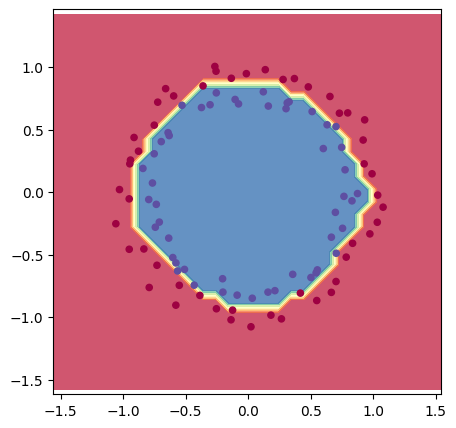

In [45]:
visualise(modelgd)

## Task 3: Adam optimiser 

There exist several different optimisers for training neural networks, and the gradient descent optimiser is one of the simplest. The optimisers most commonly used are different versions of the Adam optimiser. Here your task is to implement the Adam optimiser, following the pseudocode in Appendix A of [this paper](https://arxiv.org/pdf/2302.06675.pdf). Values for the needed parameters are given, however feel free to change them to make the optimiser perform even better.

In [46]:
def adam(model, n_steps=100):
    '''
    A function that optimises the parameters of the neural network in n_steps steps using the Adam optimiser.
    Return a list of losses and a list of accuracies during training. 
    '''
    
    losses = []
    accuracies = []
    
    b1 = 0.9
    b2 = 0.999
    eps = 1e-8
    lmbda = 1.0
    eta = 5e-2
    
    Nparam = len(model.parameters())
    
    m = np.zeros(Nparam)
    v = np.zeros(Nparam)
    
    for step in range(n_steps):
        
        t = step + 1
    
        # forward
        total_loss, acc = loss(X, y, model)
        losses.append(total_loss.data)
        accuracies.append(acc)

        # backward
        model.zero_grad()
        total_loss.backward()

        # update (adam)
        lr = eta * learning_rate(step, n_steps)

        for i, p in enumerate(model.parameters()):
            # compute the first and second moments
            m[i] = b1*m[i] + (1-b1)*p.grad
            v[i] = b2*v[i] + (1-b2)*(p.grad**2)

            # bias correction
            m_hat = m[i] / (1 - b1**t)
            v_hat = v[i] / (1 - b2**t)

            # update the parameter
            p.data -= lr * m_hat / (np.sqrt(v_hat) + lmbda*eps)


        if step % 10 == 0 or step == n_steps-1:
            print(f"step {step} loss {total_loss.data}, accuracy {acc*100}%")
    
    return losses, accuracies


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 1.0381065297865302, accuracy 50.0%
step 10 loss 0.811489087642323, accuracy 71.0%
step 20 loss 0.4230815269748685, accuracy 87.0%
step 30 loss 0.13764174075929425, accuracy 99.0%
step 40 loss 0.08314757514484566, accuracy 100.0%
step 50 loss 0.04645921140715026, accuracy 100.0%
step 60 loss 0.032197664648199634, accuracy 100.0%
step 70 loss 0.027915488582333066, accuracy 100.0%
step 80 loss 0.025724776710

<Figure size 640x480 with 0 Axes>

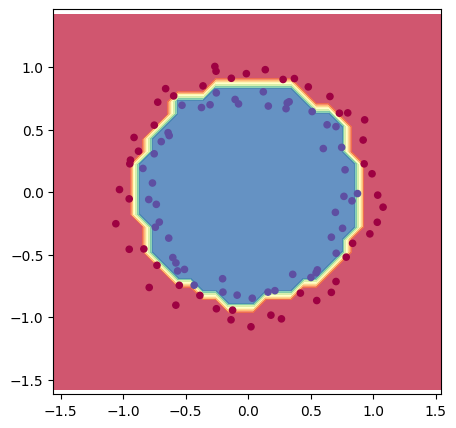

In [47]:
modeladam = initialise(n_neurons = 16)
lossadam, accadam = adam(modeladam)

visualise(modeladam)

## Task 4: Lion optimiser

Google recently (Feb 2023) published the [Lion](https://arxiv.org/pdf/2302.06675.pdf) optimiser which they claim to be even more efficient in training neural networks than the Adam optimiser. Let us try to implement it here! You should follow the pseudocode in Appendix A of [this paper](https://arxiv.org/pdf/2302.06675.pdf). Values for the needed parameters are given, however feel free to change them to make the optimiser perform even better.

In [48]:
def lion(model, n_steps=100):
    '''
    A function that optimizes the parameters of the neural network in n_steps steps using the Lion optimizer.
    Returns a list of losses and a list of accuracies during training. 
    '''

    losses = []
    accuracies = []

    b1 = 0.9
    b2 = 0.999
    eps = 1e-8
    lmbda = 1.0
    eta = 5e-2

    Nparam = len(model.parameters())

    m = np.zeros(Nparam)

    for step in range(n_steps):

        # forward
        total_loss, acc = loss(X, y, model)
        losses.append(total_loss.data)
        accuracies.append(acc)

        # backward
        model.zero_grad()
        total_loss.backward()

        # update (lion)
        lr = eta * learning_rate(step, n_steps)

        for i in range(Nparam):
            p = model.parameters()[i]

            #update model parameters
            c = b1 * m[i] + (1-b1)*p.grad
            p.data -= lr*(np.sign(c) + lmbda*p.data)

            #update EMA of gradient
            m[i] = b2 * m[i] + (1-b2)*p.grad


        if step % 10 == 0 or step == n_steps-1:
            print(f"step {step} loss {total_loss.data}, accuracy {acc*100}%")
    
    return losses, accuracies

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337
step 0 loss 2.192395359926364, accuracy 51.0%
step 10 loss 0.870540959536752, accuracy 50.0%
step 20 loss 0.7485123436929836, accuracy 52.0%
step 30 loss 0.7158789529610453, accuracy 79.0%
step 40 loss 0.6921043945846445, accuracy 61.0%
step 50 loss 0.6376994877293027, accuracy 64.0%
step 60 loss 0.6233018193034113, accuracy 69.0%
step 70 loss 0.5898476368525114, accuracy 84.0%
step 80 loss 0.5548067797827178, accura

<Figure size 640x480 with 0 Axes>

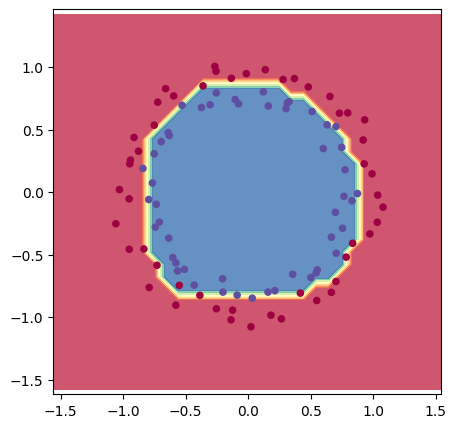

In [49]:
modellion = initialise(n_neurons = 16)
losslion, acclion = lion(modellion)

visualise(modellion)

## Task 5: Compare the optimisers

Compare the three optimisers. Plot the accuracies and losses as functions of optimisation steps. Compute the generalisation error for the three optimisers for the simple test set defined below. Comment on your results. Which optimiser gives the best decision boundary between the inner and outer circle?

(0.0, 99.0)

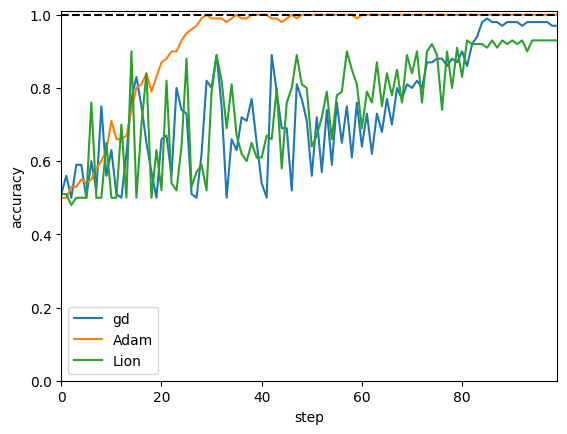

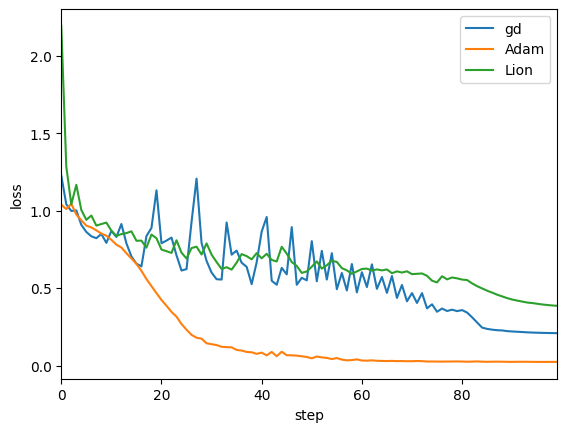

In [50]:
### PLOT ACCURACY ###


plt.figure()
plt.plot(accgd,label = 'gd')
plt.plot(accadam, label = 'Adam')
plt.plot(acclion, label = 'Lion')
plt.plot([0,len(accgd)-1],[1,1], '--', c='k')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.xlim([0,len(accgd)-1])
plt.ylim([0,1.01])

### PLOT LOSS ###

plt.figure()
plt.plot(lossgd,   label = 'gd')
plt.plot(lossadam, label = 'Adam')
plt.plot(losslion, label = 'Lion')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim([0,len(lossgd)-1])

Gradient descent generalisation error = 0.02953409448722283
Adam generalisation error = 0.08206775921493784
Lion generalisation error = 0.0060401386756321895


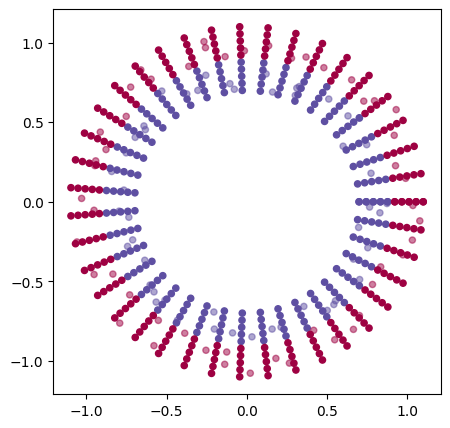

In [51]:
# Test set
phi = np.linspace(0, 2*np.pi, 40)
r   = np.linspace(0.7, 1.1,   10)

Xtest = np.zeros((len(phi)*len(r), 2))
i=0
for r0 in r:
    for phi0 in phi:
        Xtest[i,:] = np.array([r0*np.cos(phi0),r0*np.sin(phi0)])
        i+=1
ytest = np.hstack([(1*(radius<0.9)-1*(radius>0.9))*np.ones(len(phi), dtype=np.intp) for radius in r])

plt.figure(figsize=(5,5))
plt.scatter(Xtest[:,0], Xtest[:,1], c=ytest, s=20, cmap='Spectral')
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='Spectral', alpha=0.5)

### GENERALISATION ERROR ###
# The generalisation error is the difference between the loss on the test set and training set.
g_err_gd = np.abs(loss(Xtest, ytest, modelgd)[0].data - lossgd[-1])
g_err_adam = np.abs(loss(Xtest, ytest, modeladam)[0].data - lossadam[-1])
g_err_lion = np.abs(loss(Xtest, ytest, modellion)[0].data - losslion[-1])

print(f'Gradient descent generalisation error = {g_err_gd}')
print(f'Adam generalisation error = {g_err_adam}')
print(f'Lion generalisation error = {g_err_lion}')

**Discussion of results:**

From the accuraries plot, The Adam optimser aprroaches to 100%, the most quickly. The Lion optimser aproaches 100% slightly faster than the gradient descent.
From the losses plot, the Adams has the smallest losses on average, followed by the Lions and then the gradient descent. The loss in the Adams dropps more quickly than the loss in the other functions.    

From the generalisation error values, the Adams optismer has the highest generalisation error and Lion has the smallest. This is likely because the Adam optimser overfits and would explain why the accuracy and loss decreases quickly over the steps. So, the best optimser is Lion, which is expected.
